# Detecting the anomalous activity of a ship’s engine

A poorly maintained ship engine in the supply chain industry can lead to inefficiencies, increased fuel consumption, higher risks of malfunctions, and potential safety hazards. Your challenge in this project is to apply critical thinking and ML concepts to design and implement a robust anomaly detection model.

<br></br>

## **Business context**
You are provided with a real data set to identify anomalous activity in a ship’s engine functionality (Devabrat,  2022). As you work through this project, keep in mind that, typically speaking, anomalies would make up a minority of the data points (i.e., about 1% to 5% of the data points would be anomalies).

The data set contains six important features continuously monitored to evaluate the engine's status as ‘good’ or ‘bad’. These features are:
- **Engine rpm (revolutions per minute):** A high rpm indicates the engine is operating at a higher speed than designed for prolonged periods, which can lead to overheating, excessive wear, and eventual failure. A low rpm could signal a lack of power, issues with fuel delivery, or internal mechanical problems.
- **Lubrication oil pressure:** Low lubrication oil pressure indicates insufficient lubrication, leading to increased friction, overheating, and engine damage. A high lubrication oil pressure could signal a blockage in the oil delivery system, potentially causing seal or gasket failure.
- **Fuel pressure:** High fuel pressure can cause poor engine performance and incomplete combustion, indicating fuel pump or filter issues. A low fuel pressure may result in excessive fuel consumption, poor emissions, or damage to the fuel injectors.
- **Coolant pressure:** Low coolant pressure indicates a potential leak in the cooling system or a coolant pump failure, risking engine overheating. A high coolant pressure could be a sign of a blockage in the cooling system or a failing head gasket, which can also lead to overheating.
- **Lubrication oil temperature:** High lubrication oil temperature suggests the oil is overheating, which can degrade its lubricating properties and lead to engine damage. A low lubrication oil temperature may indicate it is not reaching its optimal operating temperature, potentially causing inadequate lubrication.
- **Coolant temperature:** High coolant temperature signals overheating, which various issues, including a failed thermostat, coolant leak, or insufficient coolant flow can cause. A low coolant temperature could suggest the engine is not reaching its optimal operating temperature, affecting performance and efficiency.

Issues with engines could lead to engine malfunctions, potential safety hazards, and downtime (e.g. delayed deliveries), resulting in the breakdown of a ship’s overall functionality, consequently impacting the business, such as affecting revenue via failure to deliver goods. By predicting timely maintenance, the business aims to increase profit by reducing downtime, reducing safety risks for the crew, limiting fuel consumption, and increasing customer satisfaction through timely deliveries.


In [ ]:
# URL to import data set from GitHub.
# url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

df = pd.read_csv('https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv')


# Understand the data quality

Let's have a look at the data to identify null and repeated values, as well as report basic statistics of the features to get a feel about their distribution.

In [ ]:
#get a feel of the data, see if any null values
df.info()
print('\n')
print('First few rows:')
print(df.head(), '\n')

#calculate number of unique values for each column
unique_values = df.nunique()
print("Unique_values:")
print(unique_values, '\n')

print("duplicated_values:")
print(df.duplicated().sum(), '\n')

#see the vales for different percentiles, including median and 95%
print("Basic statistics:")
print(df.describe(percentiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]), '\n')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


First few rows:
   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         682          2.391656       4.617196          2.848982   
1         605          5.466877       6.424361          5.727520   
2         658          3.434232       3.680896          1.678708   
3         749          2.094656       7.120927          1.639670   
4         676          3.538228       5.956472          3.225336   

   lub oil temp  Coolant temp  
0    

# Visualise the distributions, outliers checking histograms & box-plots



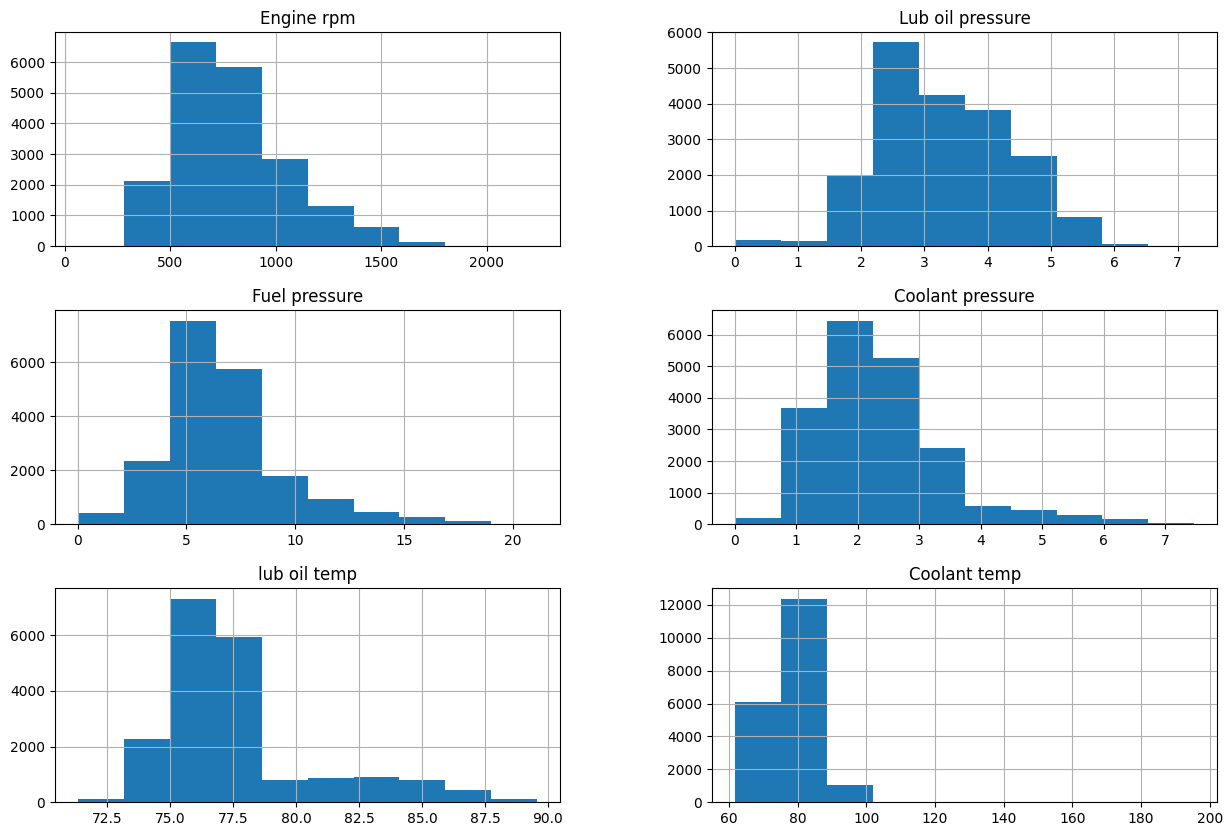

In [ ]:
df.hist(figsize=(15,10))
plt.show()

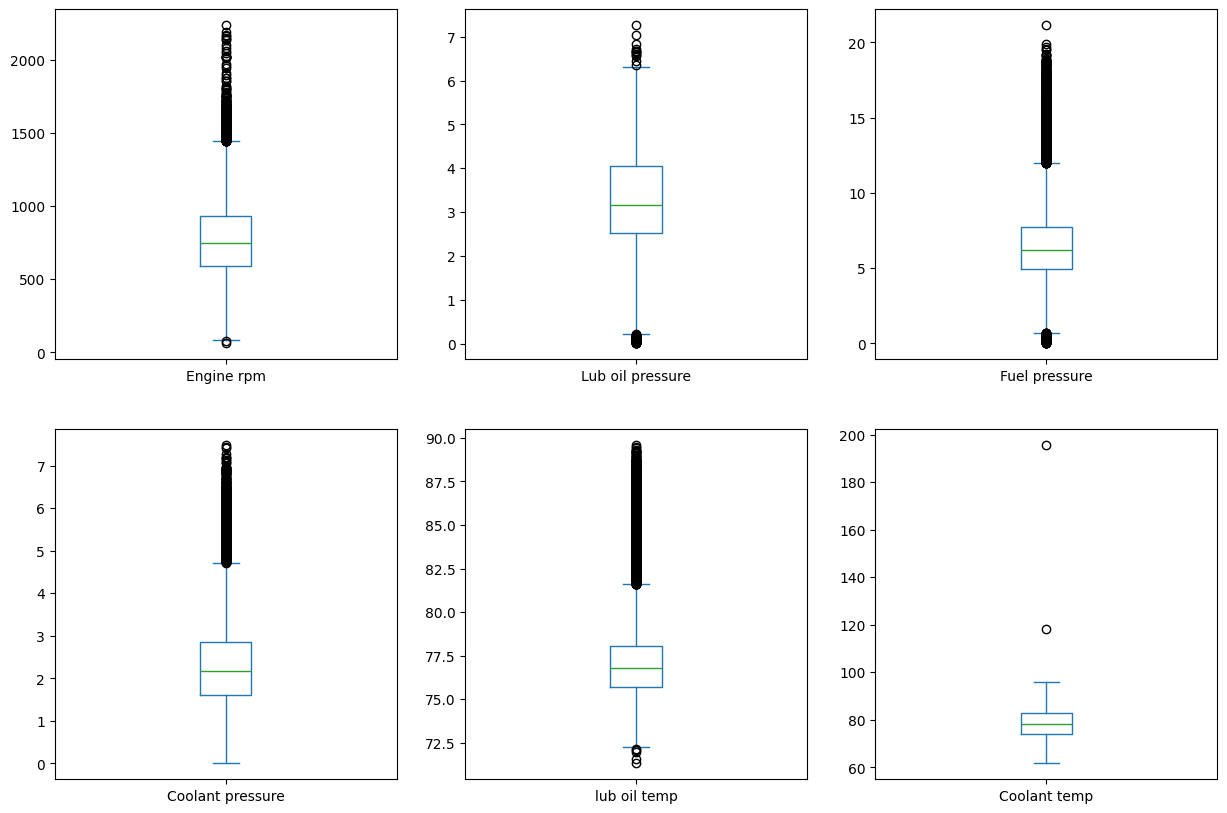

In [ ]:
#plot boxplots
df.plot(kind='box', subplots=True, layout=(2,3), figsize=(15,10))
plt.show()

# Observations - feature data quality and distributions
- There are no null values
- All features are numerical / quantitative
- Relatively less number of unique values for Engine RPM, however no evidence to think the values are erroneous
- Appears to have large number of outliers for all features except Coolant temp

# Outlier identification based on IQR

In [ ]:
# Create a flag for each feature to mark if beyond IQR
df['Coolant pressure_outlier'] = 0
df['Coolant temp_outlier'] = 0
df['Engine rpm_outlier'] = 0
df['Fuel pressure_outlier'] = 0
df['Lub oil pressure_outlier'] = 0
df['lub oil temp_outlier'] = 0

#Calculate 25th and 75th percentile values for each feature
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

#Calculate IQR for each feature
IQR = Q3 - Q1

#Calculate outlier borders for each feature
IQR_Border_Upper = Q3 + (1.5 * IQR)
IQR_Border_Lower = Q1 - (1.5 * IQR)

#Populate outlier flags for each feature
df.loc[(df['Coolant pressure'] > IQR_Border_Upper['Coolant pressure']) |
 (df['Coolant pressure'] < IQR_Border_Lower['Coolant pressure']), 'Coolant pressure_outlier'] = 1
df.loc[(df['Coolant temp'] > IQR_Border_Upper['Coolant temp']) |
 (df['Coolant temp'] < IQR_Border_Lower['Coolant temp']), 'Coolant temp_outlier'] = 1
df.loc[(df['Engine rpm'] > IQR_Border_Upper['Engine rpm']) |
 (df['Engine rpm'] < IQR_Border_Lower['Engine rpm']), 'Engine rpm_outlier'] = 1
df.loc[(df['Fuel pressure'] > IQR_Border_Upper['Fuel pressure']) |
 (df['Fuel pressure'] < IQR_Border_Lower['Fuel pressure']), 'Fuel pressure_outlier'] = 1
df.loc[(df['Lub oil pressure'] > IQR_Border_Upper['Lub oil pressure']) |
 (df['Lub oil pressure'] < IQR_Border_Lower['Lub oil pressure']), 'Lub oil pressure_outlier'] = 1
df.loc[(df['lub oil temp'] > IQR_Border_Upper['lub oil temp']) |
 (df['lub oil temp'] < IQR_Border_Lower['lub oil temp']), 'lub oil temp_outlier'] = 1



In [ ]:
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Coolant pressure_outlier,Coolant temp_outlier,Engine rpm_outlier,Fuel pressure_outlier,Lub oil pressure_outlier,lub oil temp_outlier
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,0,0,0,0,0,0
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,1,0,0,0,0,0
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,0,0,0,0,0,1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,0,0,0,0,0,0
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,0,0,0,0,0,0


# Find samples where at least 2 features have outliers based on IQR

In [ ]:
df['IQR_outlier_count'] = df[['Coolant pressure_outlier', 'Coolant temp_outlier', 'Engine rpm_outlier', 'Fuel pressure_outlier', 'Lub oil pressure_outlier', 'lub oil temp_outlier']].sum(axis=1)
df.head()

oneOrMoreOutliers = len(df[df['IQR_outlier_count'] >= 1])
print(f"Number of samples with at least 2 outliers: {oneOrMoreOutliers}")
print(f"proportion of outliers: {oneOrMoreOutliers/len(df)}")

twoOrMoreOutliers = len(df[df['IQR_outlier_count'] >= 2])
print(f"Number of samples with at least 2 outliers: {twoOrMoreOutliers}")
print(f"proportion of outliers: {twoOrMoreOutliers/len(df)}")

threeOrMoreOutliers = len(df[df['IQR_outlier_count'] >= 3])
print(f"Number of samples with at least 3 outliers: {threeOrMoreOutliers}")
print(f"proportion of outliers: {threeOrMoreOutliers/len(df)}")


Number of samples with at least 2 outliers: 4636
proportion of outliers: 0.2373176350140773
Number of samples with at least 2 outliers: 422
proportion of outliers: 0.02160225236754543
Number of samples with at least 3 outliers: 11
proportion of outliers: 0.0005630918863578193


# Conclusion - IQR
- As the outliers are expected to be 1-5 % of all observations, 2 or more outliers are more appropriate as a measure corresponds to ~ 2% observations
- Outliers based on one or more features give too many outliers , around 24%
- Outliers based on three or more features give too few outliers , around 0.006%
- IQR proves to be a very fast method to identify outliers without relying on more sophisticated machine learning algorithms.
- Limited flexibility as IQR is a one dimensional model, the attampt here is to consider multiple columns at a time

# One Class SVM to identify outliers

In [ ]:
#extract dataframe which includes all rows and fist 6 columns of df (original data)
X = df.iloc[:, 0:6]
# Scale data for better SVM performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def oneClassSVM(X_scaled, kernel, gamma, nu):

  #Predict outliers initially with gamma and nu equal to 0.5
  model = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
  model.fit(X_scaled)

  # Predict the class (normal or anomaly).
  y_pred = model.predict(X_scaled)
  print(y_pred)

  nbOutliers = len(y_pred[y_pred == -1])
  print(f"Number of outliers from one class SVM with gamma = {gamma}  and nu = {nu}: {nbOutliers}")
  print(f"proportion of outliers: {nbOutliers/len(y_pred)}")

  return model, y_pred

In [ ]:
#Let's try the model with gamma =0.5 and nu=0.5 first
model_05_05, y_pred_05_05 = oneClassSVM (X_scaled, kernel='rbf', gamma=0.5, nu=0.05)

[ 1 -1  1 ...  1  1  1]
Number of outliers from one class SVM with gamma = 0.5  and nu = 0.05: 1043
proportion of outliers: 0.053391348861018685


gamma=0.5, nu=0.05 gives outliers more than the expected 1-5% range. So we will try different parameters. Nu=0.03 should pull the no of outliers to around 3%, within range

In [ ]:
model_05_03, y_pred_05_03 = oneClassSVM (X_scaled, kernel='rbf', gamma=0.5, nu=0.03)

model_05_01, y_pred_05_01 = oneClassSVM (X_scaled, kernel='rbf', gamma=0.5, nu=0.01)

[1 1 1 ... 1 1 1]
Number of outliers from one class SVM with gamma = 0.5  and nu = 0.03: 737
proportion of outliers: 0.037727156385973896
[1 1 1 ... 1 1 1]
Number of outliers from one class SVM with gamma = 0.5  and nu = 0.01: 611
proportion of outliers: 0.03127719477860251


# Visualise the anomaly predictions from one Class SVM


In [ ]:
# Visualise the data
def plot_model(y_pred, X_plot_2d, title):
    # Create a grid for plotting decision boundaries and anomaly detection.
    # Since we are plotting in 2D, the meshgrid is also 2D.
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

    # Plot setup.
    plt.figure(figsize=(12, 8))
    plt.title(title)

    # Plot also the data points, using different markers for normals and anomalies.
    # Use X_plot_2d for the scatter plot.
    sns.scatterplot(x=X_plot_2d[:, 0], y=X_plot_2d[:, 1], hue=np.where(y_pred == 1, 'Normal', 'Anomaly'),
                    style=np.where(y_pred == -1, 'Anomaly', 'Normal'), markers={'Anomaly': 'X', 'Normal': 'o'},
                    palette={'Normal': 'deepskyblue', 'Anomaly': 'red'}, alpha=0.6, edgecolor='k')

    # Plot aesthetics.
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

Calculate PCA to aid a 2D visualisation - this requires dropping the no of features from 6 to 2.

In [ ]:
# Apply PCA.
def apply_pca(df, n_components=None):
  pca = PCA(n_components)
  X_pca = pca.fit_transform(df)
  df_pca = pd.DataFrame({
    'PC': range(1, len(pca.explained_variance_ratio_) + 1),
    'Explained Variance': pca.explained_variance_ratio_
  })

  return X_pca, df_pca, pca

X_pca, df_pca, pca = apply_pca(X_scaled, n_components=6)
print(df_pca)

   PC  Explained Variance
0   1            0.189948
1   2            0.176930
2   3            0.170714
3   4            0.156753
4   5            0.156464
5   6            0.149191


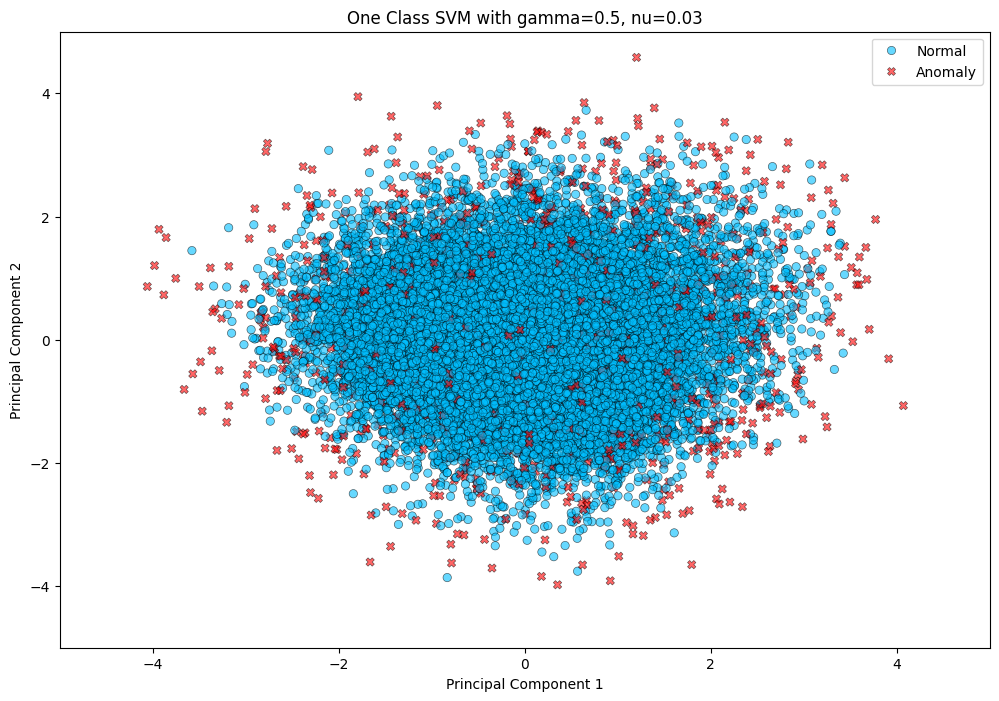

In [ ]:
plot_model(y_pred_05_05, X_pca, 'One Class SVM with gamma=0.5, nu=0.03')

Let's try for gamma =0.03 and n=0.03 to see the impact on outliers

In [ ]:
model_03_03, y_pred_03_03 = oneClassSVM (X_scaled, kernel='rbf', gamma=0.3, nu=0.03)

[1 1 1 ... 1 1 1]
Number of outliers from one class SVM with gamma = 0.3  and nu = 0.03: 589
proportion of outliers: 0.03015101100588687


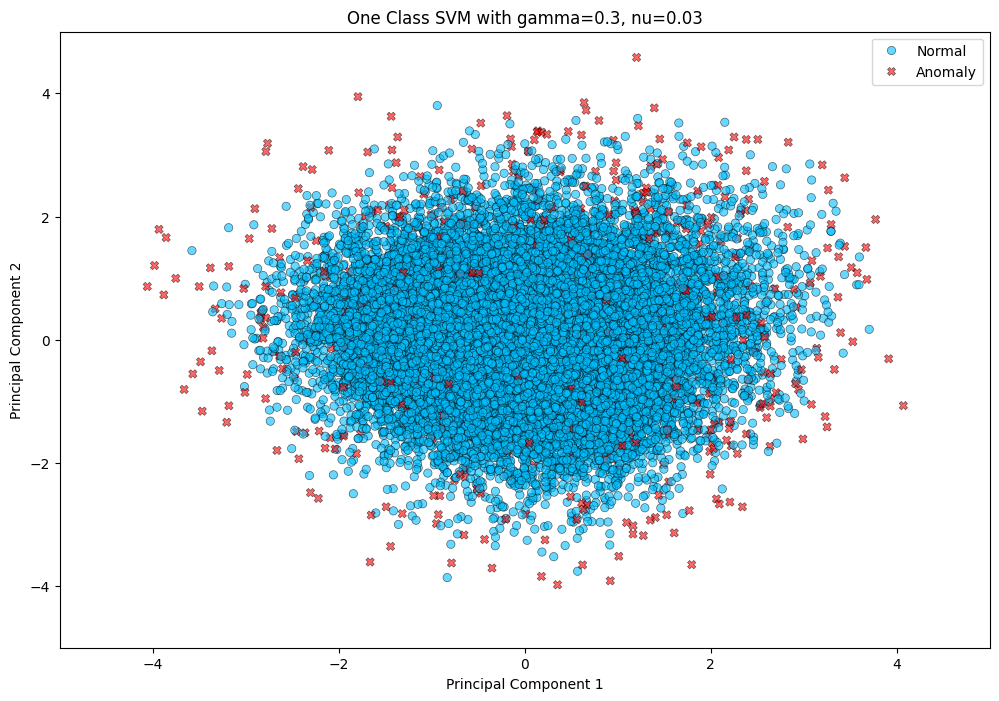

In [ ]:
plot_model(y_pred_03_03 , X_pca, 'One Class SVM with gamma=0.3, nu=0.03')

#Conclusions - one Class SVM:
- We are able to mark anomalies within the desired outlier proportions with different gamma & nu variations. For example Gamma=0.3 and nu=0.3 provides 589 outliers (circa 3% of all observations)
- The anomalies are particularly sensitive to nu parameter, however the sensitivity drops from around nu= 3%. Nu parameters less than 3% results in marginally smaller number of outliers.
- The scatterplots based on first 2 principal components show there is no clear seperation between normal observations and anomalies. This may be a limitation of the first 2 principal components - the cumulative variance explained by these is only around 37%

# Isolation tree method to identify anomalies

In [ ]:

def isolationForest(X, n_estimators, contamination):

  iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
  iso_forest.fit(X)
  isoForestPred = iso_forest.predict(X)

  #count the number & proportion of anomalies predicted
  nbOutliers = len(isoForestPred[isoForestPred == -1])
  print(f"Number of outliers from isolation forest with estimators= {n_estimators}  and contamination = {contamination}: {nbOutliers}")
  print(f"proportion of outliers: {nbOutliers/len(isoForestPred)}")
  return isoForestPred


Note the Isolation tree is not meant to use scaled features, as in fact this may potentially hinder the algorithm to isolate outliers.

Number of outliers from isolation forest with estimators= 100  and contamination = 0.03: 587
proportion of outliers: 0.03004863066291272
Number of outliers from isolation forest with estimators= 10  and contamination = 0.03: 587
proportion of outliers: 0.03004863066291272
Number of outliers from isolation forest with estimators= 1000  and contamination = 0.03: 587
proportion of outliers: 0.03004863066291272


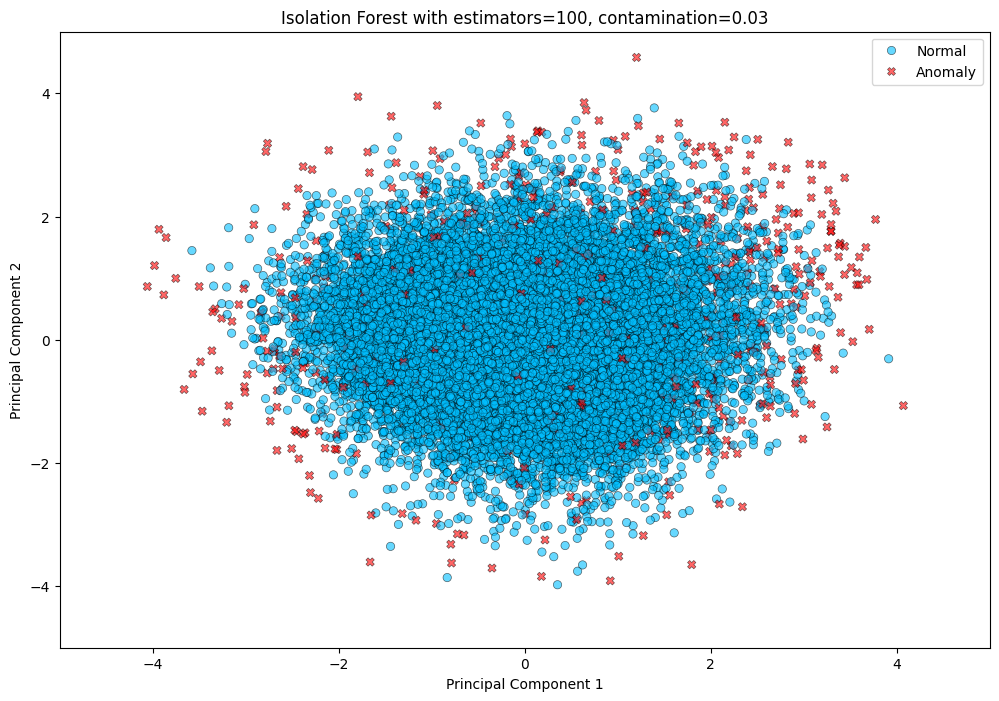

In [ ]:

# Initialize and fit Isolation Forest. Let's set the contamination at 0.3 to imply 3% of samples are outliers
isoForestPred_100_03= isolationForest(X, n_estimators=100, contamination=0.03)

# Now let's see if  #estimators have a significant effect on the #outliers
isoForestPred_10_03= isolationForest(X, n_estimators=10, contamination=0.03)
isoForestPred_1000_03= isolationForest(X, n_estimators=1000, contamination=0.03)

# Let's plot the anomalies via isolation forest , with first 2 PCA values on horizontal and vertical axis
plot_model(isoForestPred_100_03, X_pca, 'Isolation Forest with estimators=100, contamination=0.03')

If the number of estimators within Isolation Forest increased from 100 to 1000, the compute time increases somewhat significantly, however without an apparent improvement in the result. So let's stick to 100 estimators.

Number of outliers from isolation forest with estimators= 100  and contamination = 0.02: 391
proportion of outliers: 0.020015357051446123


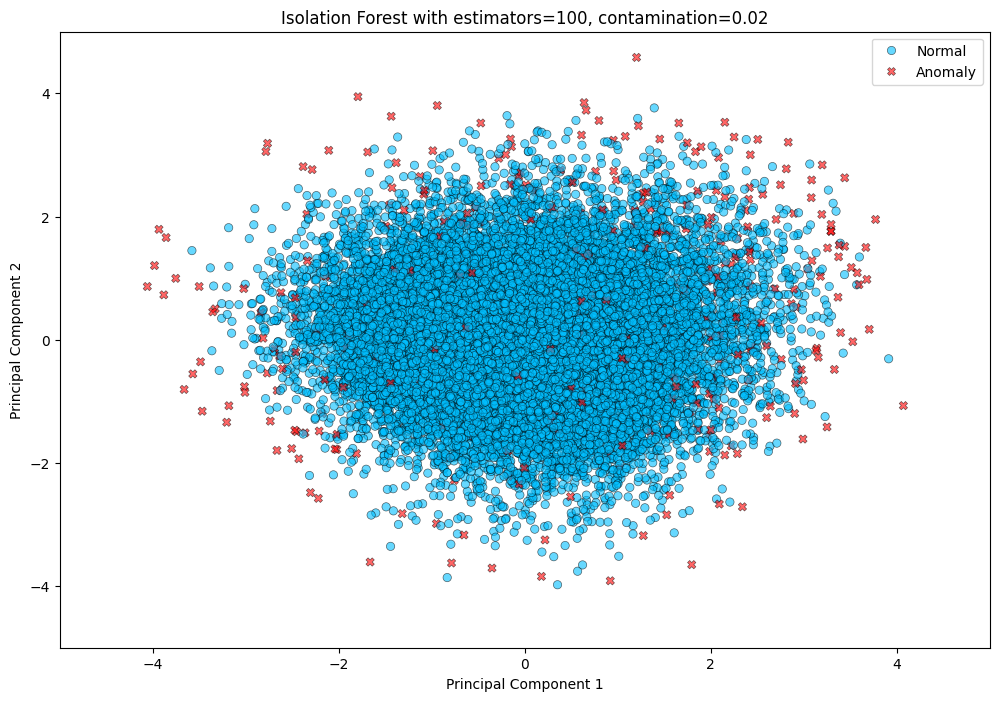

In [ ]:
# Let's set the contamination at 0.3 to imply 2% of samples are outliers
isoForestPred_100_02= isolationForest(X, n_estimators=100, contamination=0.02)

plot_model(isoForestPred_100_02, X_pca, 'Isolation Forest with estimators=100, contamination=0.02')

#Conclusions - Isolation Forest
- Faster results compared to one class SVM as the method only focuses on the anomalies and does not try to identify 'normal' observations
- Contamination parameter is very effective in determining how many outliers will be identified
- Number of estimators parameter (number of trees for averaging) did not have a visible impact on resulting anomalies.

# Compiling results from 3 methods to analyze outliers

For this, we will add outlier predictions from One class SVM and Isolation Forest which result in the data frame (we tried to keep consistency between methods, generating around 3% outliers), and IQR method based on 2 or more features(~2% outliers). We then look at how many outliers from each method are overlapping.

In [ ]:
df['OneClassSVM_03_03'] = y_pred_03_03
df['IsolationForest_100_03'] = isoForestPred_100_03
df['IQR2orMore'] = df[['Coolant pressure_outlier', 'Coolant temp_outlier', 'Engine rpm_outlier', 'Fuel pressure_outlier', 'Lub oil pressure_outlier', 'lub oil temp_outlier']].sum(axis=1)
df['IQR2orMore'] = df['IQR2orMore'].apply(lambda x: -1 if x >= 2 else 1)
df_outliersOverall = df[(df['OneClassSVM_03_03'] == -1) & (df['IsolationForest_100_03'] == -1) & (df['IQR2orMore'] == -1)]
nbOutliersOverall = len(df_outliersOverall)
print(f"Number of outliers: {nbOutliersOverall}")
print(f"proportion of outliers: {nbOutliersOverall/len(df)}")


Number of outliers: 139
proportion of outliers: 0.007115433836703353


If we are to advise finding outliers based on the intersection of 3 methods, we end up with 0.7% of outliers which is less than the guidance. Let's try to accept more outliers from one class SVM and isolation forest to see if we can increase the outliers from the intersection to 1% or above. We do not have much control on how many outliers IQR would give so we will use '2 or more features' criteria

In [ ]:
model_05_045, y_pred_05_045 = oneClassSVM (X_scaled, kernel='rbf', gamma=0.5, nu=0.045)

[1 1 1 ... 1 1 1]
Number of outliers from one class SVM with gamma = 0.5  and nu = 0.045: 965
proportion of outliers: 0.04939851548502688


In [ ]:
isoForestPred_100_049= isolationForest(X, n_estimators=100, contamination=0.049)

Number of outliers from isolation forest with estimators= 100  and contamination = 0.049: 958
proportion of outliers: 0.04904018428461735


In [ ]:
df['OneClassSVM_05_045'] = y_pred_05_045
df['IsolationForest_100_049'] = isoForestPred_100_049
df_outliersIsoSVM = df[(df['OneClassSVM_05_045'] == -1) & (df['IsolationForest_100_049'] == -1)]
nbOutliersIsoSVM = len(df_outliersIsoSVM)
print(f"Number of outliers: {nbOutliersIsoSVM}")
print(f"proportion of outliers: {nbOutliersIsoSVM/len(df)}")

Number of outliers: 561
proportion of outliers: 0.028717686204248784


When we dictate around %4.9 outliers individually from Isolation Forest and One Class SVM, the intersection of outliers from both methods correspond to about 3% of observations. So a roughly 57% of the outliers from these methods overlap.

In [ ]:
df['OneClassSVM_05_045'] = y_pred_05_045
df['IsolationForest_100_049'] = isoForestPred_100_049
#df['IQR2orMore'] = df[['Coolant pressure_outlier', 'Coolant temp_outlier', 'Engine rpm_outlier', 'Fuel pressure_outlier', 'Lub oil pressure_outlier', 'lub oil temp_outlier']].sum(axis=1)
#df['IQR2orMore'] = df['IQR2orMore'].apply(lambda x: -1 if x >= 2 else 1)
df_outliersOverall2 = df[(df['OneClassSVM_05_045'] == -1) & (df['IsolationForest_100_049'] == -1) & (df['IQR2orMore'] == -1)]
nbOutliersOverall2 = len(df_outliersOverall2)
print(f"Number of outliers: {nbOutliersOverall2}")
print(f"proportion of outliers: {nbOutliersOverall2/len(df)}")

Number of outliers: 190
proportion of outliers: 0.009726132582544152


If we look at overlapping outliers from 3 methods, we identify just under 1% of the overall observations as high priority outliers (190 observations). The next course of action must be taken after a discussion of the results with the ship engineers.

### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]